In [1]:
!nvidia-smi

Mon Mar 30 08:46:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 1.x
import os
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed

TensorFlow 1.x selected.


Using TensorFlow backend.


In [3]:
drive.mount('/melissakou')

Drive already mounted at /melissakou; to attempt to forcibly remount, call drive.mount("/melissakou", force_remount=True).


In [0]:
os.chdir('/melissakou/My Drive/Colab Notebooks/kaggle_walmart')

## Load Data

In [0]:
calendar = pd.read_csv('m5-forecasting-accuracy/calendar.csv')
sales = pd.read_csv('m5-forecasting-accuracy/sales_train_validation.csv')
prices = pd.read_csv('m5-forecasting-accuracy/sell_prices.csv')

In [6]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [7]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [8]:
print('# of item: ' + str(len(sales.item_id.unique())))
print('# of dept: ' + str(len(sales.dept_id.unique())))
print('# of cat: ' + str(len(sales.cat_id.unique())))
print('# of store: ' + str(len(sales.store_id.unique())))
print('# of state: ' + str(len(sales.state_id.unique())))

# of item: 3049
# of dept: 7
# of cat: 3
# of store: 10
# of state: 3


In [9]:
sales_store = sales.groupby('store_id').sum().T.reset_index() \
    .merge(calendar[['d', 'weekday', 'event_name_1', 'event_type_1', 'snap_CA', 'snap_TX', 'snap_WI']],
           left_on = 'index', right_on = 'd', how = 'left').drop(columns = ['d'])
sales_store = pd.get_dummies(sales_store, columns = ['weekday', 'event_name_1', 'event_type_1'])
sales_store

,index,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,snap_CA,snap_TX,snap_WI,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,event_name_1_Eid al-Fitr,event_name_1_EidAlAdha,event_name_1_Father's day,event_name_1_Halloween,event_name_1_IndependenceDay,event_name_1_LaborDay,event_name_1_LentStart,event_name_1_LentWeek2,event_name_1_MartinLutherKingDay,event_name_1_MemorialDay,event_name_1_Mother's day,event_name_1_NBAFinalsEnd,event_name_1_NBAFinalsStart,event_name_1_NewYear,event_name_1_OrthodoxChristmas,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_PresidentsDay,event_name_1_Purim End,event_name_1_Ramadan starts,event_name_1_StPatricksDay,event_name_1_SuperBowl,event_name_1_Thanksgiving,event_name_1_ValentinesDay,event_name_1_VeteransDay,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting
0,d_1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,d_2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,d_3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,d_4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,d_5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,d_1909,3722,3691,5235,2500,2901,3384,3315,3242,4194,3159,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1909,d_1910,3709,3303,5018,2458,2776,3446,3380,3324,4393,3226,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1910,d_1911,4387,4457,5623,2628,3022,3902,3691,3991,4988,3828,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1911,d_1912,5577,5884,7419,2954,3700,4483,4083,4772,5404,4686,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
sales_store[-28:]

,index,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,snap_CA,snap_TX,snap_WI,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,event_name_1_Eid al-Fitr,event_name_1_EidAlAdha,event_name_1_Father's day,event_name_1_Halloween,event_name_1_IndependenceDay,event_name_1_LaborDay,event_name_1_LentStart,event_name_1_LentWeek2,event_name_1_MartinLutherKingDay,event_name_1_MemorialDay,event_name_1_Mother's day,event_name_1_NBAFinalsEnd,event_name_1_NBAFinalsStart,event_name_1_NewYear,event_name_1_OrthodoxChristmas,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_PresidentsDay,event_name_1_Purim End,event_name_1_Ramadan starts,event_name_1_StPatricksDay,event_name_1_SuperBowl,event_name_1_Thanksgiving,event_name_1_ValentinesDay,event_name_1_VeteransDay,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting
1885,d_1886,3905,3645,5487,2445,3026,3740,3537,3039,4254,2963,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1886,d_1887,3788,3795,5493,2243,2499,2899,2924,2780,4041,3395,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1887,d_1888,3339,3489,5202,2322,2801,3137,2890,2692,3626,2861,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1888,d_1889,4076,3581,5474,2470,2631,3355,3320,2858,3908,3008,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1889,d_1890,4983,4787,6571,2581,3389,4113,4350,4362,6146,4254,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1890,d_1891,5877,6048,7206,3040,4018,4785,4292,5119,7069,5218,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1891,d_1892,6496,6542,8399,3140,4275,5170,4606,5370,6953,5474,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1892,d_1893,4812,3971,6622,2788,3032,3791,3674,3168,5010,3550,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1893,d_1894,4063,3480,6221,2632,3215,3721,3530,3231,5680,3910,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1894,d_1895,3964,3731,5685,2427,3201,3366,3771,2996,6143,3850,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Store Models

In [0]:
class StoreModel():
    def __init__(self, data, target_store):
        self.data = copy.deepcopy(data)
        self.train = copy.deepcopy(self.data[:-28])
        self.val = copy.deepcopy(self.data[-28:])
        self.target_store = target_store


    def ScaleTargetVariable(self):
        target_min = min(self.train[self.target_store])
        target_max = max(self.train[self.target_store])
        self.train[self.target_store] = (self.train[self.target_store] - target_min) / (target_max - target_min)
        self.val[self.target_store] = (self.val[self.target_store] - target_min) / (target_max - target_min)
        
        self.target_scaler = [target_min, target_max]


    def InverseScale(self, X):
        return np.array(X) * (self.target_scaler[1] - self.target_scaler[0]) + self.target_scaler[0]



    def GenerateTrain(self, past_day, future_day):
        tmp = pd.concat([self.train[self.target_store],
                         self.train['snap_' + self.target_store[:2]],
                         self.train.loc[:, 'weekday_Friday':]], axis = 1)
        X, Y = [], []
        for i in range(tmp.shape[0] - past_day - future_day):
            X.append(np.array(tmp[i : i+past_day]))
            Y.append(np.array(tmp[i+past_day : i+past_day+future_day][self.target_store]))

        self.data_X, self.data_Y = np.array(X), np.array(Y)
        self.columns = tmp.columns


    def RandomSplit(self, train_ratio, seed):
        np.random.seed(seed)
        index = np.arange(self.data_X.shape[0])
        np.random.shuffle(index)
        X, Y = self.data_X[index], self.data_Y[index]
        X_train = X[:int(X.shape[0] * train_ratio)]
        Y_train = Y[:int(Y.shape[0] * train_ratio)]
        X_val = X[int(X.shape[0] * train_ratio):]
        Y_val = Y[int(Y.shape[0] * train_ratio):]

        self.X_train, self.Y_train, self.X_val, self.Y_val = X_train, Y_train, X_val, Y_val


    def TrainLSTM(self, nodes, epoch, bs, verbose = 1):
        self.Y_train = self.Y_train[:,:,np.newaxis]
        self.Y_val = self.Y_val[:,:,np.newaxis]

        model = Sequential()
        model.add(LSTM(nodes, input_shape = (self.X_train.shape[1], self.X_train.shape[2]), return_sequences = True))
        model.add(TimeDistributed(Dense(1)))
        model.compile(loss = 'mse', optimizer = 'adam')
        model.summary()
        history = model.fit(self.X_train, self.Y_train, epochs = epoch, batch_size = bs,
                            validation_data = (self.X_val, self.Y_val), verbose = verbose)
        
        self.history = history
        self.model = model

    def DrawTrainingCurve(self):
        plt.plot(self.history.history['loss'], label = 'train_loss')
        plt.plot(self.history.history['val_loss'], label = 'val_loss')
        plt.legend()
        plt.title(self.target_store)

    def Predict(self, X):
        if len(X.shape) == 2:
            tmp = copy.deepcopy(X[np.newaxis,:,:])
        else:
            tmp = copy.deepcopy(X)
        return self.model.predict(tmp).squeeze()


    def PredictLast28(self):
        return self.model.predict(np.array(self.train[-28:][self.columns])[np.newaxis,:,:]).squeeze()


    def PredictNext28(self):
        return self.model.predict(np.array(self.val[self.columns])[np.newaxis,:,:]).squeeze()


    def DrawPredictResult(self):
        plt.plot(self.data[-56:][self.target_store], '.-')
        plt.plot(range(1885, 1913), self.InverseScale(self.PredictLast28()), '.-')
        plt.plot(range(1913, 1941), self.InverseScale(self.PredictNext28()), '.-')
        plt.title(self.target_store)

In [12]:
stores = sales.store_id.unique()
stores

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [0]:
# store_models = {}
# for store in stores:
#     model = StoreModel(data = sales_store, target_store = store)
#     model.ScaleTargetVariable()
#     model.GenerateTrain(past_day = 28, future_day = 28)
#     model.RandomSplit(train_ratio = 0.7, seed = 20200325)
#     print('Training on Store: ' + store)
#     model.TrainLSTM(nodes = 1024, epoch = 100, bs = 128, verbose = 0)
    
#     store_models[store] = model

In [0]:
# with open('store_models.pickle', 'wb') as f:
#     pickle.dump(store_models, f)
# f.close()

In [15]:
with open('store_models.pickle', 'rb') as f:
    store_models = pickle.load(f)
f.close()











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




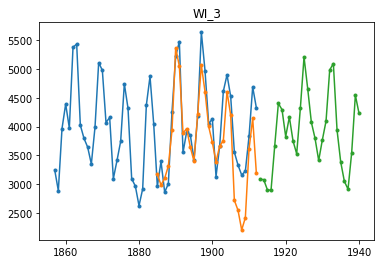

In [16]:
store_models['WI_3'].DrawPredictResult()

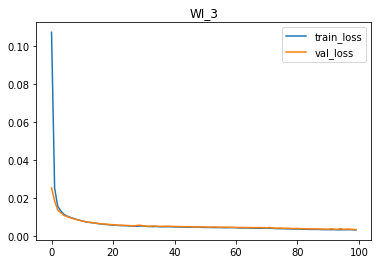

In [17]:
store_models['WI_3'].DrawTrainingCurve()

## Proportion Model

### historical average

In [18]:
hist_prop = copy.deepcopy(sales[['id', 'store_id']])
hist_prop['item_mean'] = sales.loc[:, 'd_1':'d_1885'].mean(axis = 1)
hist_prop.head()

,id,store_id,item_mean
0,HOBBIES_1_001_CA_1_validation,CA_1,0.303979
1,HOBBIES_1_002_CA_1_validation,CA_1,0.260477
2,HOBBIES_1_003_CA_1_validation,CA_1,0.144297
3,HOBBIES_1_004_CA_1_validation,CA_1,1.717241
4,HOBBIES_1_005_CA_1_validation,CA_1,0.960743


In [19]:
store_mean = sales_store[:-28].loc[:, 'CA_1':'WI_3'].mean(axis = 0)
store_mean = pd.DataFrame({'store_mean': store_mean})
store_mean

,store_mean
CA_1,4016.053581
CA_2,2949.837666
CA_3,5841.489655
CA_4,2137.646154
TX_1,2919.106631
TX_2,3768.847745
TX_3,3173.956499
WI_1,2674.684881
WI_2,3391.486472
WI_3,3350.648276


In [20]:
hist_prop = hist_prop.merge(store_mean, how = 'left', left_on = 'store_id', right_index = True)
hist_prop['historical_mean_prop'] = hist_prop['item_mean'] / hist_prop['store_mean']
hist_prop

,id,store_id,item_mean,store_mean,historical_mean_prop
0,HOBBIES_1_001_CA_1_validation,CA_1,0.303979,4016.053581,0.000076
1,HOBBIES_1_002_CA_1_validation,CA_1,0.260477,4016.053581,0.000065
2,HOBBIES_1_003_CA_1_validation,CA_1,0.144297,4016.053581,0.000036
3,HOBBIES_1_004_CA_1_validation,CA_1,1.717241,4016.053581,0.000428
4,HOBBIES_1_005_CA_1_validation,CA_1,0.960743,4016.053581,0.000239
...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,WI_3,0.538992,3350.648276,0.000161
30486,FOODS_3_824_WI_3_validation,WI_3,0.377188,3350.648276,0.000113
30487,FOODS_3_825_WI_3_validation,WI_3,0.894960,3350.648276,0.000267
30488,FOODS_3_826_WI_3_validation,WI_3,0.358621,3350.648276,0.000107


## Predict & Evaluation

### last 28 days

In [21]:
stores_pred_last28 = pd.DataFrame(columns = ['store_id'] + ['F' + str(i) for i in range(1,29)])
stores_pred_last28['store_id'] = stores
for store in stores:
    stores_pred_last28.loc[stores_pred_last28.store_id == store, 'F1':] = store_models[store].InverseScale(store_models[store].PredictLast28())
stores_pred_last28

,store_id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,CA_1,3892.72,3431.85,3431.72,3564.71,4221.36,5372.93,5817.3,4473.43,3829.16,3516.87,3543.86,4101.98,5448.23,5624.57,4146.87,3491.49,3322.53,3254.67,3683.32,5007.82,5636.72,3846.44,3513.38,3492.91,3813.23,4832.3,7175.12,4784.6
1,CA_2,2954.23,3100.94,3172.72,3375.64,3916.35,5554.95,5859.29,3767.46,3477.15,3489.66,3627.06,4155.36,6081.5,5997.12,3673.23,3426.87,3428.82,3299.8,4045.03,4551.84,3278.19,2390.2,2853.93,3009.77,3213.62,4290.9,5972.67,5590.91
2,CA_3,6045.39,5684.59,5378.16,5515.5,5879.94,7133.93,7826.29,6518.43,6068.13,5722.45,5599.92,5960.34,7371.6,7827.31,6275.79,5613.66,5335.92,4801.46,5259.12,6261.43,7400.91,5592.5,5234.59,4911.42,4753.68,5775.22,7812.12,7359.94
3,CA_4,2316.12,2208.72,2250.94,2269.29,2420.09,2813.79,2998.01,2643.75,2419.98,2241.75,2310.31,2397.24,2744.48,2834.74,2492.78,2366.8,2228.24,2148.98,2332.85,2542.62,2943.87,2574.45,2459.64,2380.25,2406.04,2537.94,3393.27,2701.28
4,TX_1,2861.67,2639.04,2665.54,2789.42,3025.25,3687.45,3858.44,2969.6,2895.46,2820.04,2890.36,3012.14,3770.42,3896.2,3256.36,3121.19,3120.89,2872.99,3026.91,3405.01,3573.75,2637.77,2444.88,2480.81,2464.15,3428.29,3898.64,4376.99
5,TX_2,3728.17,3426.68,3408.09,3561.02,3928.88,4680.13,4836.39,3864.01,3644.26,3441.28,3719.32,3814.65,4668.72,4803.04,3996.36,3660.56,3620.18,3354.1,3889.2,4277.9,4631.47,3529.21,3296.69,3435.34,3251.74,4699.39,5125.46,4846.19
6,TX_3,3320.63,3177.75,3180.19,3457.85,3742.05,4215.54,4243.22,3684.42,3496.37,3248.25,3460.11,3494,4104.24,4077.62,3701.2,3413.97,3466.91,3218.98,3788.82,3996.94,4231.22,3491.23,3124.91,3128.35,2860.49,4141.1,4386.53,3774.96
7,WI_1,2787.23,2546.43,2919.01,3093.66,3686.59,5105.45,5049.43,3351.88,3086.45,3148.39,3048.66,3664.94,5047.95,4521.14,3282.51,3240.86,3155.85,3042.57,3496.75,5013.14,5192.51,3356.31,2959.51,2798.82,2621.94,4424.11,6473.1,3719.34
8,WI_2,3761.13,4076.72,4711.43,5250.97,5548.67,6885.11,6307.96,4767,5219.76,4922.02,4704.85,5318.44,6197.76,5699.38,5592.45,5326.68,5080.71,5526.92,5378.85,5700.2,5320.74,4525.45,4159.33,4195.93,3878.25,4937.11,5108.67,3623.73
9,WI_3,3168.49,2985.88,3101.8,3316.99,3938.64,5362.26,5047.7,3886.3,3963.49,3640.59,3396.56,4219.28,5062.07,4605.52,4000.48,3723.52,3388.19,3661.68,3757.65,4606.27,4195.87,2720.84,2546.78,2207.05,2419.06,3606.06,4142.23,3192.49


In [26]:
pred_last28 = pd.merge(hist_prop[['id', 'store_id', 'historical_mean_prop']], stores_pred_last28, how = 'left', on = 'store_id')
pred_last28.loc[:, 'F1':] = pred_last28.loc[:, 'F1':].apply(lambda x: x * pred_last28['historical_mean_prop'], axis = 0)
pred_last28 = pred_last28.drop(columns = ['store_id', 'historical_mean_prop'])
pred_last28.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.294643,0.25976,0.25975,0.269816,0.319519,0.406682,0.440317,0.338598,0.289833,0.266195,0.268238,0.310482,0.412381,0.425729,0.31388,0.264274,0.251485,0.246349,0.278794,0.379046,0.426649,0.291141,0.265931,0.264381,0.288627,0.365761,0.543091,0.362151
1,HOBBIES_1_002_CA_1_validation,0.252478,0.222587,0.222578,0.231204,0.273794,0.348483,0.377304,0.290142,0.248356,0.228101,0.229851,0.26605,0.353367,0.364804,0.268962,0.226455,0.215496,0.211095,0.238896,0.324802,0.365593,0.249477,0.227875,0.226547,0.247323,0.313418,0.465372,0.310325
2,HOBBIES_1_003_CA_1_validation,0.139866,0.123307,0.123302,0.12808,0.151674,0.19305,0.209016,0.160731,0.137582,0.126361,0.127331,0.147384,0.195755,0.202091,0.148997,0.12545,0.119379,0.116941,0.132342,0.179931,0.202528,0.138203,0.126236,0.1255,0.13701,0.173625,0.257803,0.171911
3,HOBBIES_1_004_CA_1_validation,1.6645,1.46744,1.46738,1.52425,1.80503,2.29743,2.48744,1.91281,1.63733,1.50379,1.51533,1.75398,2.32963,2.40503,1.77318,1.49294,1.4207,1.39168,1.57496,2.14131,2.41023,1.64472,1.5023,1.49355,1.63052,2.06626,3.06804,2.04587
4,HOBBIES_1_005_CA_1_validation,0.931237,0.820986,0.820955,0.852769,1.00986,1.28534,1.39165,1.07016,0.916033,0.841325,0.847782,0.981297,1.30336,1.34554,0.992037,0.835254,0.794835,0.778601,0.881143,1.198,1.34845,0.920168,0.840491,0.835593,0.912223,1.15601,1.71647,1.1446


### next 28 days

In [36]:
stores_pred_next28 = pd.DataFrame(columns = ['store_id'] + ['F' + str(i) for i in range(1,29)])
stores_pred_next28['store_id'] = stores
for store in stores:
    stores_pred_next28.loc[stores_pred_next28.store_id == store, 'F1':] = store_models[store].InverseScale(store_models[store].PredictNext28())
stores_pred_next28

,store_id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,CA_1,3926.19,3542.07,3405.19,3583.14,4311.22,5500.36,5845.07,4673.26,4134.37,3891.35,3712.1,4376.93,5597.22,5761.88,4401.27,3807.97,3505.82,3440.52,3984.45,5133.99,5489.57,4048.36,3592.03,3510.74,3501.6,4216.37,5421.46,5965.94
1,CA_2,3003.08,3200.39,3330,3460.42,4327.14,6015.95,6304.14,4171.66,3761.49,3663.49,3751.83,4403.81,6229.96,6057.58,3980.01,3719.49,3622.56,3593.34,4298.94,5740.97,5636.03,3653.28,3547.6,3564.32,3460.3,4285.81,6008.83,6068.27
2,CA_3,5800.04,5377.67,5150.26,5147.62,5737.84,6767.65,7440.31,6458.75,6185.74,5855.38,5734.97,6075.32,7339.88,7915.68,6708.73,6095.69,5645.31,5381.13,5530.65,6791.11,7563.37,6032.83,5542.08,5273.57,5090.78,5544.83,6934.18,7539.03
3,CA_4,2256.78,2141.2,2140.39,2229.62,2409.67,2800.78,2953.99,2662.71,2527.38,2392.39,2392.54,2433.39,2852.59,3031.35,2603.69,2359.45,2200.69,2274.34,2401.16,2713.89,2913.2,2606.96,2505.34,2402.33,2393.73,2520.4,2865.7,3087.96
4,TX_1,2917.97,2612.14,2667.74,2625.5,2862.98,3632.13,3963.88,3136.47,2948.37,2878.07,2914.64,3262.71,4031.29,4211.5,3046.96,2775.56,2738.04,2908.25,3100.47,3902.45,4174.84,3201.83,2897.7,2851.18,2775.5,2953.81,3740.04,4067.14
5,TX_2,3736.79,3214.37,3199.69,3228.46,3625.65,4489.23,4667.67,3881.39,3529.54,3393.42,3490.38,3843.25,4705.83,4981.89,3738.12,3358.37,3146.5,3523.22,3678.27,4717.21,4938.41,3672.82,3241.65,3224.53,3262.8,3640.04,4503.71,4625.45
6,TX_3,3345.94,2969.96,2903.97,2950.26,3431.89,4053.57,4191.19,3706,3371.28,3304.65,3418.94,3680.41,4279.38,4549.16,3631.41,3386.46,3145.61,3384.27,3482.94,4244.32,4452.02,3486.8,3234.37,3144.56,3093.03,3393.53,4016.04,4151.13
7,WI_1,2626.01,2676.5,2690.35,2688.36,3686.98,4857.57,4750.49,3555.21,3400.31,3175.6,3081,3715.75,5439.3,4892.63,3507.08,3442.46,3294.69,3320.93,3842.21,4988.87,4660.24,3296.85,3094.49,3178.6,3171.95,3845.27,4946.85,4558.16
8,WI_2,3714.68,3926.01,3854.98,3775.47,4951.01,5830.41,5221.02,4826.59,5577.18,5602.01,5410.75,5984.68,6885.43,6032.79,5600.14,5312.36,4927.87,5253.81,5417.05,5542.42,6013.75,5516.7,4801.64,4423.94,4439.13,5007.56,5448.82,5056.39
9,WI_3,3084.36,3079.68,2904.58,2893.39,3658.35,4400.5,4292.8,3826.95,4164.42,3750.89,3526.48,4319.14,5205.32,4656.75,4073.92,3795.93,3411.85,3768.8,4093.37,4980.2,5092.48,3941.93,3386.48,3050.35,2912.95,3549.57,4543.13,4227.34


In [37]:
pred_next28 = pd.merge(hist_prop[['id', 'store_id', 'historical_mean_prop']], stores_pred_next28, how = 'left', on = 'store_id')
pred_next28.loc[:, 'F1':] = pred_next28.loc[:, 'F1':].apply(lambda x: x * pred_next28['historical_mean_prop'], axis = 0)
pred_next28 = pred_next28.drop(columns = ['store_id', 'historical_mean_prop'])
pred_next28.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.297177,0.268102,0.257742,0.271211,0.32632,0.416327,0.442419,0.353724,0.312934,0.29454,0.280972,0.331294,0.423659,0.436122,0.333136,0.288229,0.265359,0.260416,0.301587,0.388596,0.415511,0.306424,0.271884,0.265731,0.265039,0.319141,0.410355,0.451568
1,HOBBIES_1_002_CA_1_validation,0.254649,0.229735,0.220857,0.232399,0.279622,0.356748,0.379106,0.303103,0.268151,0.252389,0.240763,0.283884,0.363031,0.37371,0.285462,0.246981,0.227384,0.223149,0.258428,0.332986,0.356048,0.262573,0.232976,0.227703,0.22711,0.27347,0.351631,0.386945
2,HOBBIES_1_003_CA_1_validation,0.141068,0.127267,0.122349,0.128742,0.154902,0.197628,0.210014,0.167911,0.148548,0.139816,0.133376,0.157263,0.201109,0.207025,0.158138,0.136821,0.125964,0.123618,0.143162,0.184465,0.197241,0.145458,0.129062,0.126141,0.125813,0.151495,0.194793,0.214357
3,HOBBIES_1_004_CA_1_validation,1.67882,1.51457,1.45604,1.53213,1.84345,2.35192,2.49932,1.99826,1.76783,1.66392,1.58727,1.87155,2.39334,2.46375,1.88196,1.62826,1.49907,1.47114,1.70373,2.19526,2.34731,1.73106,1.53593,1.50117,1.49726,1.8029,2.31818,2.551
4,HOBBIES_1_005_CA_1_validation,0.939246,0.847353,0.814608,0.857179,1.03135,1.31583,1.39829,1.11796,0.989046,0.93091,0.888029,1.04707,1.339,1.37839,1.0529,0.910963,0.838682,0.823059,0.953183,1.22818,1.31325,0.968471,0.859305,0.839858,0.837672,1.00866,1.29695,1.42721


### evaluation

In [0]:
from typing import Union
from tqdm.auto import tqdm as tqdm

class WRMSSEEvaluator(object):
    
    group_ids = ( 'all_id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id',
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], ['item_id', 'state_id'], ['item_id', 'store_id'])

    def __init__(self, 
                 train_df: pd.DataFrame, 
                 valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, 
                 prices: pd.DataFrame):
        '''
        intialize and calculate weights
        '''
        self.calendar = calendar
        self.prices = prices
        self.train_df = train_df
        self.valid_df = valid_df
        self.train_target_columns = [i for i in self.train_df.columns if i.startswith('d_')]
        self.weight_columns = self.train_df.iloc[:, -28:].columns.tolist()

        self.train_df['all_id'] = "all"

        self.id_columns = [i for i in self.train_df.columns if not i.startswith('d_')]
        self.valid_target_columns = [i for i in self.valid_df.columns if i.startswith('d_')]

        if not all([c in self.valid_df.columns for c in self.id_columns]):
            self.valid_df = pd.concat([self.train_df[self.id_columns], self.valid_df],
                                      axis=1, 
                                      sort=False)
        self.train_series = self.trans_30490_to_42840(self.train_df, 
                                                      self.train_target_columns, 
                                                      self.group_ids)
        self.valid_series = self.trans_30490_to_42840(self.valid_df, 
                                                      self.valid_target_columns, 
                                                      self.group_ids)
        self.weights = self.get_weight_df()
        self.scale = self.get_scale()
        self.train_series = None
        self.train_df = None
        self.prices = None
        self.calendar = None

    def get_scale(self):
        '''
        scaling factor for each series ignoring starting zeros
        '''
        scales = []
        for i in tqdm(range(len(self.train_series))):
            series = self.train_series.iloc[i].values
            series = series[np.argmax(series!=0):]
            scale = ((series[1:] - series[:-1]) ** 2).mean()
            scales.append(scale)
        return np.array(scales)
    
    def get_name(self, i):
        '''
        convert a str or list of strings to unique string 
        used for naming each of 42840 series
        '''
        if type(i) == str or type(i) == int:
            return str(i)
        else:
            return "--".join(i)
    
    def get_weight_df(self) -> pd.DataFrame:
        """
        returns weights for each of 42840 series in a dataFrame
        """
        day_to_week = self.calendar.set_index("d")["wm_yr_wk"].to_dict()
        weight_df = self.train_df[["item_id", "store_id"] + self.weight_columns].set_index(
            ["item_id", "store_id"]
        )
        weight_df = (
            weight_df.stack().reset_index().rename(columns={"level_2": "d", 0: "value"})
        )
        weight_df["wm_yr_wk"] = weight_df["d"].map(day_to_week)
        weight_df = weight_df.merge(
            self.prices, how="left", on=["item_id", "store_id", "wm_yr_wk"]
        )
        weight_df["value"] = weight_df["value"] * weight_df["sell_price"]
        weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)[
            "value"
        ]
        weight_df = weight_df.loc[
            zip(self.train_df.item_id, self.train_df.store_id), :
        ].reset_index(drop=True)
        weight_df = pd.concat(
            [self.train_df[self.id_columns], weight_df], axis=1, sort=False
        )
        weights_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False)):
            lv_weight = weight_df.groupby(group_id)[self.weight_columns].sum().sum(axis=1)
            lv_weight = lv_weight / lv_weight.sum()
            for i in range(len(lv_weight)):
                weights_map[self.get_name(lv_weight.index[i])] = np.array(
                    [lv_weight.iloc[i]]
                )
        weights = pd.DataFrame(weights_map).T / len(self.group_ids)

        return weights

    def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
        '''
        transform 30490 sries to all 42840 series
        '''
        series_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False, disable=dis)):
            tr = df.groupby(group_id)[cols].sum()
            for i in range(len(tr)):
                series_map[self.get_name(tr.index[i])] = tr.iloc[i].values
        return pd.DataFrame(series_map).T
    
    def get_rmsse(self, valid_preds) -> pd.Series:
        '''
        returns rmsse scores for all 42840 series
        '''
        score = ((self.valid_series - valid_preds) ** 2).mean(axis=1)
        rmsse = (score / self.scale).map(np.sqrt)
        return rmsse

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds],
                                axis=1, 
                                sort=False)
        valid_preds = self.trans_30490_to_42840(valid_preds, 
                                                self.valid_target_columns, 
                                                self.group_ids, 
                                                True)
        self.rmsse = self.get_rmsse(valid_preds)
        self.contributors = pd.concat([self.weights, self.rmsse], 
                                      axis=1, 
                                      sort=False).prod(axis=1)
        return np.sum(self.contributors)

In [28]:
%time


train_fold_df = sales.iloc[:, :-28]
valid_fold_df = sales.iloc[:, -28:].copy()

e = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [35]:
e.score(np.array(pred_last28.iloc[:, 1:]))

0.8607692878371518

In [63]:
e.rmsse['WI_3']

0.6994552510933078

In [65]:
pred_next28

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.297177,0.268102,0.257742,0.271211,0.32632,0.416327,0.442419,0.353724,0.312934,0.29454,0.280972,0.331294,0.423659,0.436122,0.333136,0.288229,0.265359,0.260416,0.301587,0.388596,0.415511,0.306424,0.271884,0.265731,0.265039,0.319141,0.410355,0.451568
1,HOBBIES_1_002_CA_1_validation,0.254649,0.229735,0.220857,0.232399,0.279622,0.356748,0.379106,0.303103,0.268151,0.252389,0.240763,0.283884,0.363031,0.37371,0.285462,0.246981,0.227384,0.223149,0.258428,0.332986,0.356048,0.262573,0.232976,0.227703,0.22711,0.27347,0.351631,0.386945
2,HOBBIES_1_003_CA_1_validation,0.141068,0.127267,0.122349,0.128742,0.154902,0.197628,0.210014,0.167911,0.148548,0.139816,0.133376,0.157263,0.201109,0.207025,0.158138,0.136821,0.125964,0.123618,0.143162,0.184465,0.197241,0.145458,0.129062,0.126141,0.125813,0.151495,0.194793,0.214357
3,HOBBIES_1_004_CA_1_validation,1.67882,1.51457,1.45604,1.53213,1.84345,2.35192,2.49932,1.99826,1.76783,1.66392,1.58727,1.87155,2.39334,2.46375,1.88196,1.62826,1.49907,1.47114,1.70373,2.19526,2.34731,1.73106,1.53593,1.50117,1.49726,1.8029,2.31818,2.551
4,HOBBIES_1_005_CA_1_validation,0.939246,0.847353,0.814608,0.857179,1.03135,1.31583,1.39829,1.11796,0.989046,0.93091,0.888029,1.04707,1.339,1.37839,1.0529,0.910963,0.838682,0.823059,0.953183,1.22818,1.31325,0.968471,0.859305,0.839858,0.837672,1.00866,1.29695,1.42721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0.496157,0.495403,0.467237,0.465436,0.58849,0.707873,0.690549,0.615611,0.669898,0.603375,0.567277,0.694785,0.837338,0.749095,0.655339,0.610621,0.548836,0.606257,0.658468,0.801125,0.819187,0.634107,0.544757,0.490686,0.468582,0.57099,0.730818,0.680018
30486,FOODS_3_824_WI_3_validation,0.347212,0.346684,0.326974,0.325713,0.411827,0.495371,0.483249,0.430807,0.468796,0.422244,0.396982,0.486213,0.585972,0.524219,0.458608,0.427314,0.384077,0.42426,0.460798,0.56063,0.573269,0.44375,0.381222,0.343383,0.327915,0.399581,0.511428,0.475879
30487,FOODS_3_825_WI_3_validation,0.823835,0.822583,0.775816,0.772825,0.977148,1.17537,1.14661,1.02218,1.11232,1.00186,0.941925,1.15364,1.39034,1.24382,1.08815,1.0139,0.911306,1.00665,1.09334,1.33021,1.3602,1.05289,0.904532,0.814751,0.77805,0.948091,1.21347,1.12913
30488,FOODS_3_826_WI_3_validation,0.33012,0.329618,0.310878,0.30968,0.391554,0.470986,0.45946,0.4096,0.445719,0.401458,0.37744,0.462278,0.557126,0.498413,0.436033,0.406279,0.365171,0.403375,0.438114,0.533032,0.545049,0.421906,0.362456,0.32648,0.311773,0.379911,0.486253,0.452453


In [66]:
sample_submission = pd.read_csv('m5-forecasting-accuracy/sample_submission.csv')
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
sample_submission[:len(pred_next28)] = pred_next28
sample_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.297177,0.268102,0.257742,0.271211,0.32632,0.416327,0.442419,0.353724,0.312934,0.29454,0.280972,0.331294,0.423659,0.436122,0.333136,0.288229,0.265359,0.260416,0.301587,0.388596,0.415511,0.306424,0.271884,0.265731,0.265039,0.319141,0.410355,0.451568
1,HOBBIES_1_002_CA_1_validation,0.254649,0.229735,0.220857,0.232399,0.279622,0.356748,0.379106,0.303103,0.268151,0.252389,0.240763,0.283884,0.363031,0.37371,0.285462,0.246981,0.227384,0.223149,0.258428,0.332986,0.356048,0.262573,0.232976,0.227703,0.22711,0.27347,0.351631,0.386945
2,HOBBIES_1_003_CA_1_validation,0.141068,0.127267,0.122349,0.128742,0.154902,0.197628,0.210014,0.167911,0.148548,0.139816,0.133376,0.157263,0.201109,0.207025,0.158138,0.136821,0.125964,0.123618,0.143162,0.184465,0.197241,0.145458,0.129062,0.126141,0.125813,0.151495,0.194793,0.214357
3,HOBBIES_1_004_CA_1_validation,1.67882,1.51457,1.45604,1.53213,1.84345,2.35192,2.49932,1.99826,1.76783,1.66392,1.58727,1.87155,2.39334,2.46375,1.88196,1.62826,1.49907,1.47114,1.70373,2.19526,2.34731,1.73106,1.53593,1.50117,1.49726,1.8029,2.31818,2.551
4,HOBBIES_1_005_CA_1_validation,0.939246,0.847353,0.814608,0.857179,1.03135,1.31583,1.39829,1.11796,0.989046,0.93091,0.888029,1.04707,1.339,1.37839,1.0529,0.910963,0.838682,0.823059,0.953183,1.22818,1.31325,0.968471,0.859305,0.839858,0.837672,1.00866,1.29695,1.42721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
sample_submission.to_csv('submission_1.csv', index = False)